In [16]:

from inference import run
# import matplotlib.pyplot as plt
from app_utils import bucket_sort, do_sorting, xml_to_csv, annotate_planogram_compliance
import pandas as pd
import numpy as np
import streamlit as st 
import cv2
import json
from tempfile import NamedTemporaryFile
import matplotlib.pyplot as plt
%matplotlib inline

target_names = ['Bottle,100PLUS ACTIVE 1.5L','Bottle,100PLUS ACTIVE 500ML','Bottle,100PLUS LEMON LIME 1.5L',
 'Bottle,100PLUS ORANGE 500ML', 'Bottle,100PLUS ORIGINAL 1.5L',
 'Bottle,100PLUS TANGY ORANGE 1.5L','Bottle,100PLUS ZERO 1.5L', 'Bottle,100PLUS ZERO 500ML','Packet,F:M MAGNOLIA CHOC 1L',
 'Bottle,F&N GINGER ADE 1.5L','Bottle,F&N GRAPE 1.5L','Bottle,F&N ICE CREAM SODA 1.5L','Bottle,F&N LYCHEE PEAR 1.5L','Bottle,F&N ORANGE 1.5L',
 'Bottle,F&N PINEAPPLE PET 1.5L','Bottle,F&N SARSI 1.5L','Bottle,F&N SS ICE LEM TEA RS 500ML','Bottle,F&N SS ICE LEMON TEA RS 1.5L','Bottle,F&N SS ICE LEMON TEA 1.5L','Bottle,F&N SS ICE LEMON TEA 500ML',
 'Bottle,F&N SS ICE PEACH TEA 1.5L','Bottle,SS ICE LEMON GT 1.48L','Bottle,SS WHITE CHRYS TEA 1.48L','Packet,FARMHOUSE FRESH MILK 1L FNDM','Packet,FARMHOUSE PLAIN LF 1L',
 'Packet,PURA FRESH MILK 1L FS','Packet,NUTRISOY REG NO SUGAR ADDED 1L','Packet,NUTRISOY PLAIN 475ML','Packet,NUTRISOY PLAIN 1L','Packet,NUTRISOY OMEGA RD SUGAR 1L','Packet,NUTRISOY OMEGA NSA 1L',
 'Packet,NUTRISOY ALMOND 1L','Packet,MAGNOLIA FRESH MILK 1L FNDM','Packet,FM MAG FC PLAIN 200ML', 'Packet,MAG OMEGA PLUS PLAIN 200ML','Packet,MAG KURMA MILK 500ML','Packet,MAG KURMA MILK 1L',
 'Packet,MAG CHOCOLATE FC 500ML','Packet,MAG BROWN SUGAR SS MILK 1L','Packet,FM MAG LFHC PLN 500ML','Packet,FM MAG LFHC OAT 500ML','Packet,FM MAG LFHC OAT 1L','Packet,FM MAG FC PLAIN 500ML',
 'Void,PARTIAL VOID', 'Void,FULL VOID','Bottle,F&N SS ICE LEM TEA 500ML'] 


real_master_annotations = [[(32, 12), (8, 4)], [(36, 1), (41, 6), (50, 4), (51, 3), (52, 2)], [(23, 5), (24, 6), (54,5)]]



In [22]:
master_planogram_file = "/home/abhi/streamlit-app/sample_master_planogram.jpeg"
planogram_to_Score = "/home/abhi/streamlit-app/sample_planogram.jpg"

print("Finding the amster annotations with the YOLOv5 model predictions")
master = cv2.imread(master_planogram_file)
master_results = run(weights='base_line_best_model_exp5.pt',
source=master_planogram_file, imgsz=[640, 640],conf_thres=0.6, iou_thres=0.6)


master_bb_df = pd.DataFrame(master_results[0][1].tolist(), columns =["xmin","ymin", "xmax", "ymax", "conf", "cls"])
master_sorted_df = do_sorting(master_bb_df).astype(int)





Finding the amster annotations with the YOLOv5 model predictions


YOLOv5 🚀 8e8cb19 Python-3.8.10 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080, 10015MiB)

Fusing layers... 
Model summary: 224 layers, 7175275 parameters, 0 gradients


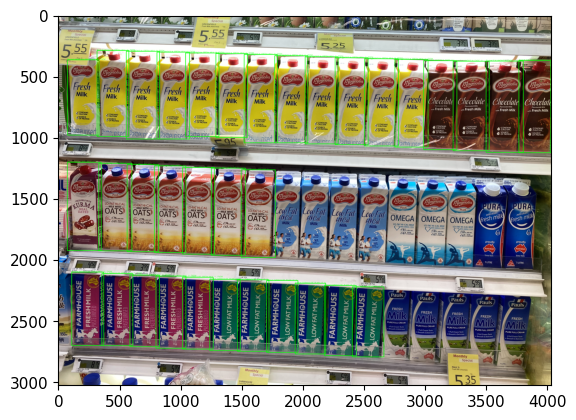

In [23]:
for i, row in master_sorted_df.iterrows():
    xyxy = row[['xmin', 'ymin', 'xmax', 'ymax']].values
    label = f'{target_names[row["cls"]]}'
    color = (0,255, 0)
    # org = (int(xyxy[0]), int(xyxy[1]) )
    top_left = (int(row['xmin']), int(row['ymin']))
    bottom_right = (int(row['xmax']), int(row['ymax']))
    cv2.rectangle(master, top_left, bottom_right , color,  3, cv2.LINE_8)
    
    cv2.putText(master, label, top_left, cv2. FONT_HERSHEY_SIMPLEX  , 0.5, color)

master = cv2.cvtColor(master, cv2.COLOR_BGR2RGB)
plt.imshow(master)

In [24]:
row

xmin           2407
ymin           2222
xmax           2665
ymax           2794
conf              0
cls              24
idx              31
line_number       3
Name: 33, dtype: int64

In [15]:
# master_sorted_dfmaster_annotations = [[(32, 12), (8, 4)], [(36, 1), (41, 6), (50, 4), (51, 3), (52, 2)], [(23, 5), (24, 6), (54,5)]]

In [25]:
n_rows = int(master_sorted_df.line_number.max())
n_cols = int(master_sorted_df.groupby('line_number').size().reset_index(name='counts')['counts'].max())
non_null_product = 101
print("master size", n_rows, n_cols)
master_annotations = []
master_table = np.zeros((int(n_rows), int(n_cols))) + non_null_product
for i, row  in master_sorted_df.groupby('line_number'):
    # print(f"Adding products in the row {i} to the detected planogram", row.cls.tolist())
    print(f"Linenumber {i}")
    products  =row.cls.tolist()
    col_len = min(len(products), n_cols)
    print("col size: ", col_len)
    print("row size: ", i-1)
    if n_rows <= (i-1):
        print("more rows than expected in the predictions")
        break
    master_table[int(i-1), 0:col_len] = products[:col_len]
    annotations = [ (int(k), int(v)) for k,v in list(zip(row.cls.unique(), row.cls.value_counts().tolist())) ]
    master_annotations.append(annotations)

master size 3 16
Linenumber 1
col size:  16
row size:  0
Linenumber 2
col size:  7
row size:  1
Linenumber 3
col size:  11
row size:  2


Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds


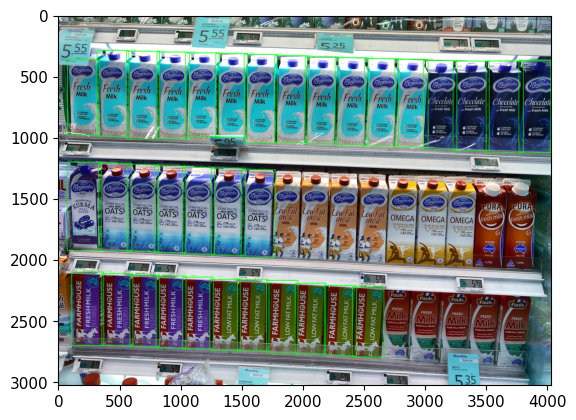

In [26]:
wrong_indexes = np.where(master_table != master_table)
correct_indexes = np.where(master_table == master_table)
annotated_planogram = annotate_planogram_compliance(master, master_sorted_df,correct_indexes, wrong_indexes, target_names)
annotated_planogram = cv2.cvtColor(annotated_planogram, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_planogram)

In [27]:
# master_annotations
# master_results

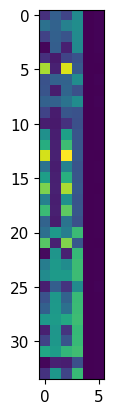

In [28]:
# master_table

plt.imshow(master_results[0][1].cpu())

In [29]:

# uploaded_img = '/content/drive/My Drive/0.CV/0.Planogram_Compliance/planogram_data/images/test/IMG_5718.jpg'
result_list = run(weights='base_line_best_model_exp5.pt',
    source=planogram_to_Score, imgsz=[640, 640])


bb_df = pd.DataFrame(result_list[0][1].tolist(), columns =["xmin","ymin", "xmax", "ymax", "conf", "cls"])
sorted_df = do_sorting(bb_df)
non_null_product = 101
print("master size", n_rows, n_cols)
detected_table = np.zeros((n_rows, n_cols)) + non_null_product
for i, row  in sorted_df.groupby('line_number'):
    # print(f"Adding products in the row {i} to the detected planogram", row.cls.tolist())
    products  =row.cls.tolist()
    col_len = min(len(products), n_cols)
    print("col size: ", col_len)
    print("row size: ", i-1)
    if n_rows <= (i-1):
        print("more rows than expected in the predictions")
        break
    detected_table[int(i-1), 0:col_len] = products[:col_len]



YOLOv5 🚀 8e8cb19 Python-3.8.10 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080, 10015MiB)

Fusing layers... 
Model summary: 224 layers, 7175275 parameters, 0 gradients


master size 3 16
col size:  16
row size:  0.0
col size:  8
row size:  1.0
col size:  11
row size:  2.0


In [43]:
(np.ma.masked_equal(master_table, non_null_product)  == detected_table).sum()

32

In [44]:
score = (np.ma.masked_equal(master_table, non_null_product)  == detected_table).sum() / (master_table != non_null_product).sum()
score

0.9411764705882353

In [46]:
detected_table 16+5 , 0+2+

array([[         32,          32,          32,          32,          32,          32,          32,          32,          32,          32,          32,          32,           8,           8,           8,           8],
       [         36,          36,          36,          41,          41,          41,          41,          41,         101,         101,         101,         101,         101,         101,         101,         101],
       [         23,          23,          23,          23,          23,          24,          24,          24,          24,          24,          24,         101,         101,         101,         101,         101]])

In [45]:
master_table

array([[         32,          32,          32,          32,          32,          32,          32,          32,          32,          32,          32,          32,           8,           8,           8,           8],
       [         36,          41,          41,          41,          41,          41,          41,         101,         101,         101,         101,         101,         101,         101,         101,         101],
       [         23,          23,          23,          23,          23,          24,          24,          24,          24,          24,          24,         101,         101,         101,         101,         101]])

In [35]:
(master_table == detected_table != non_null_product).sum() , (master_table != non_null_product).sum()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [9]:


#     annotate_df = sorted_xml_df[["xmin","ymin", "xmax", "ymax", "line_number","cls"]].astype(int)
# else:
uploaded_img = cv2.imread(planogram_to_Score)
annotate_df = sorted_df[["xmin","ymin", "xmax", "ymax", "line_number","cls"]].astype(int)


mask = master_table!=non_null_product
m_detected_table = np.ma.masked_array(master_table, mask=mask)
m_annotated_table = np.ma.masked_array(detected_table, mask=mask)

#  wrong_indexes = np.ravel_multi_index(master_table*mask != detected_table*mask, master_table.shape)
wrong_indexes = np.where(master_table != detected_table)
correct_indexes = np.where(master_table == detected_table)
annotated_planogram = annotate_planogram_compliance(uploaded_img, annotate_df,correct_indexes, wrong_indexes, target_names)

Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds
Error: single positional indexer is out-of-bounds


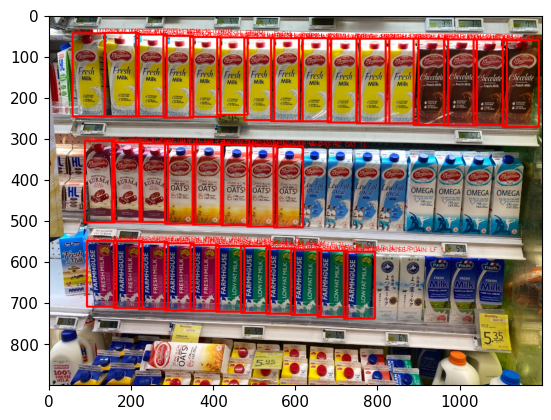

In [11]:
annotated_planogram = cv2.cvtColor(annotated_planogram, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_planogram)